In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

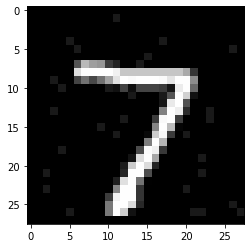

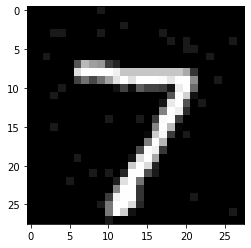

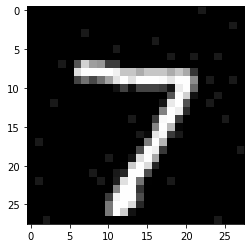

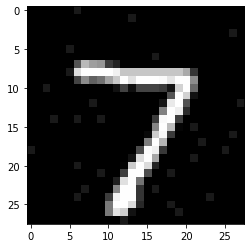

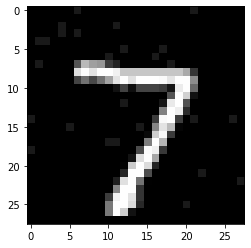

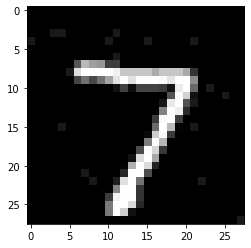

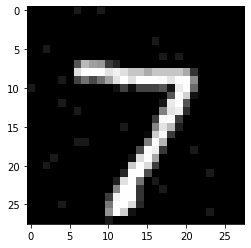

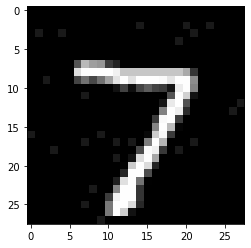

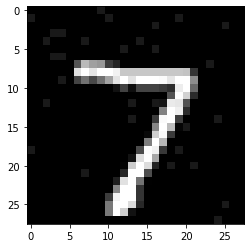

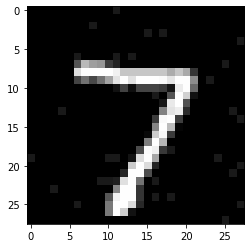

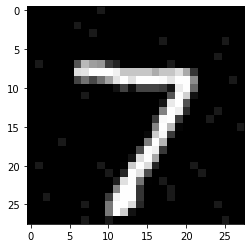

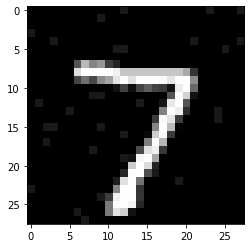

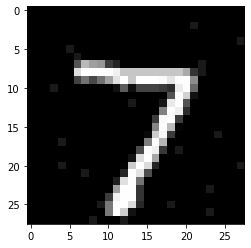

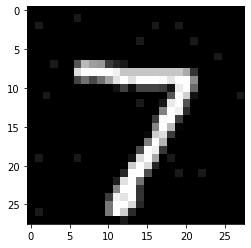

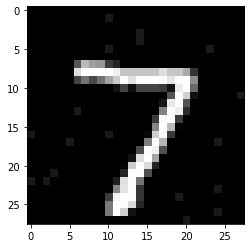

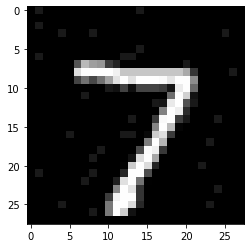

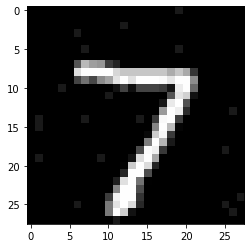

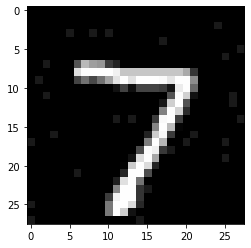

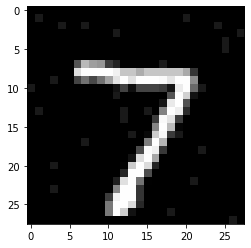

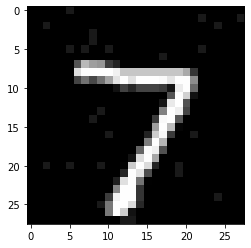

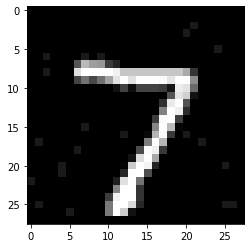

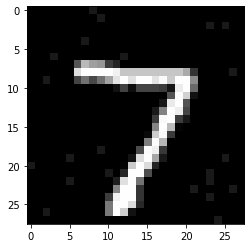

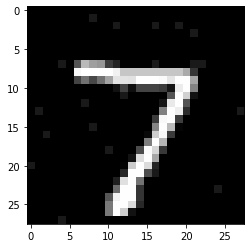

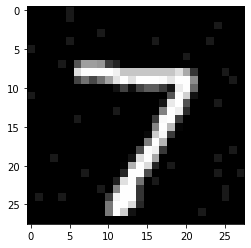

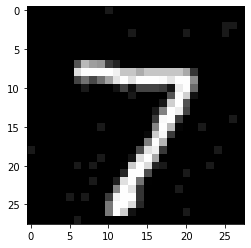

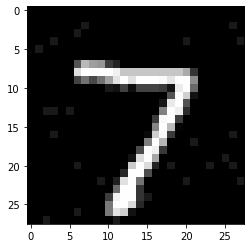

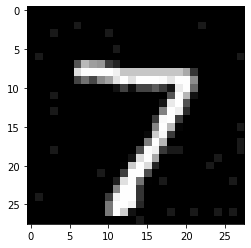

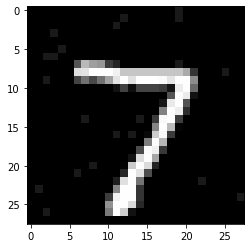

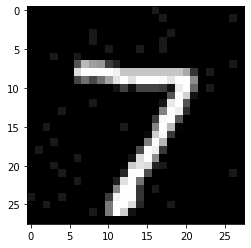

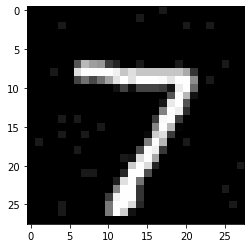

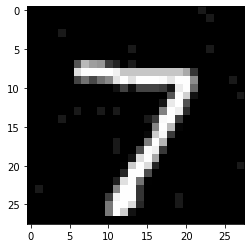

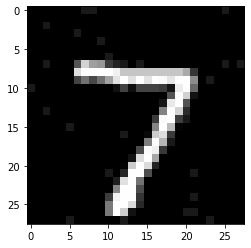

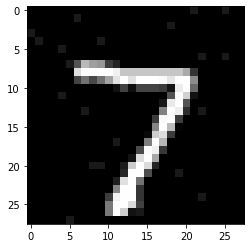

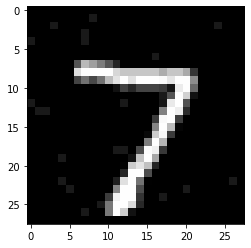

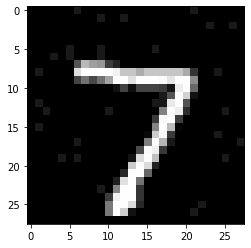

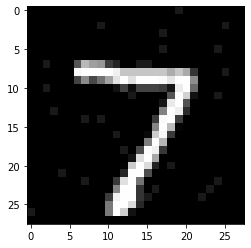

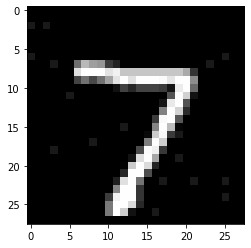

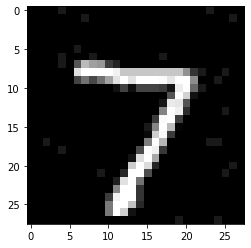

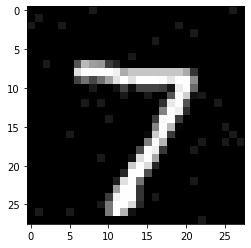

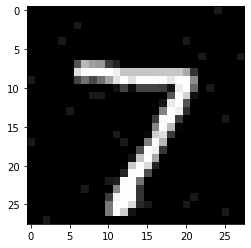

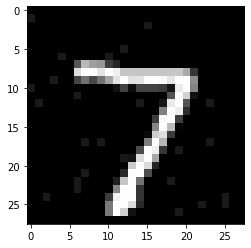

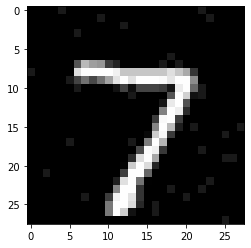

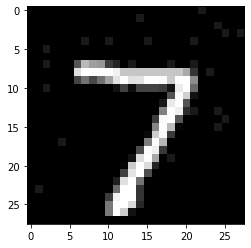

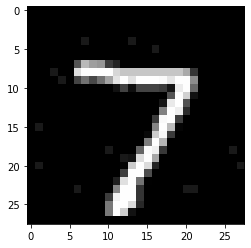

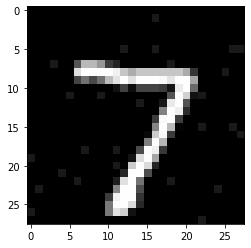

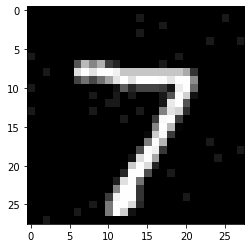

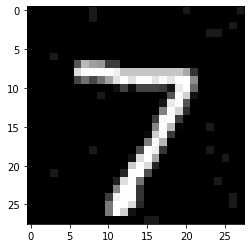

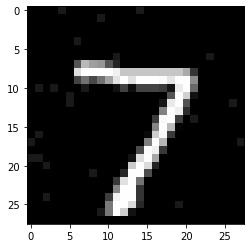

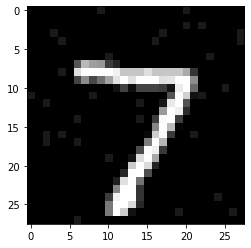

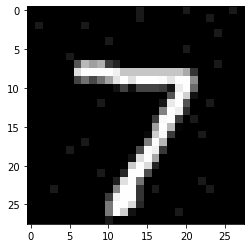

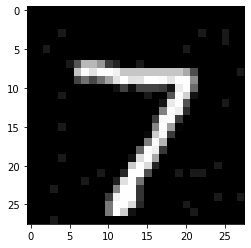

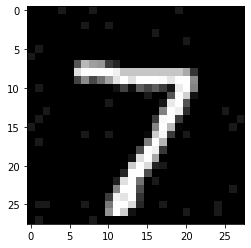

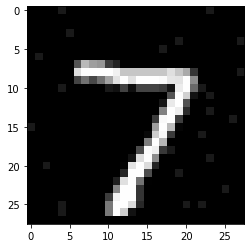

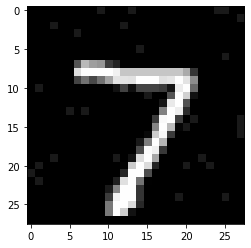

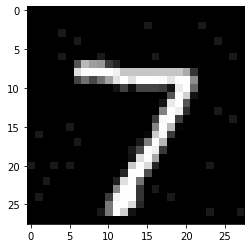

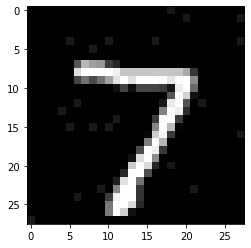

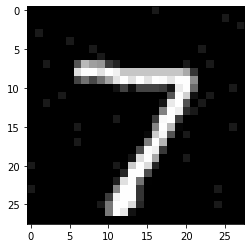

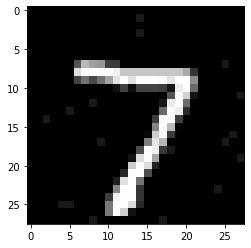

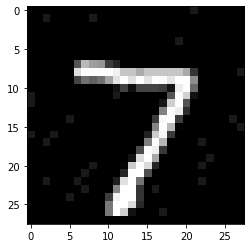

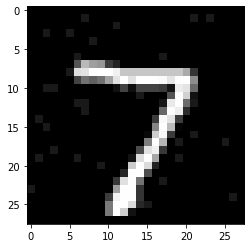

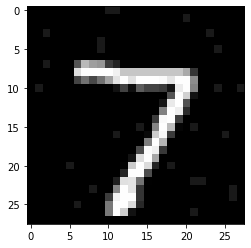

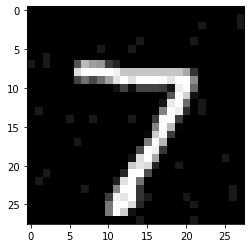

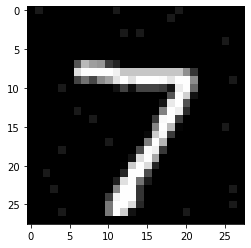

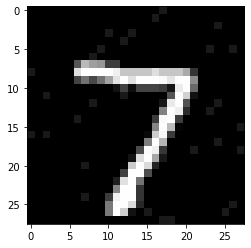

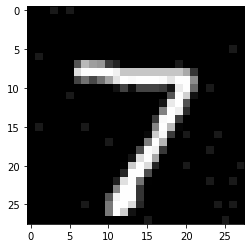

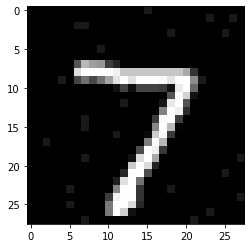

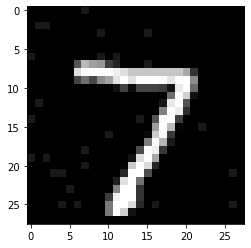

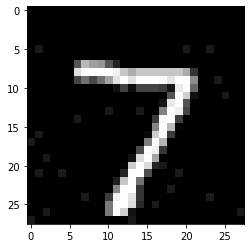

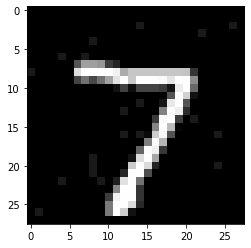

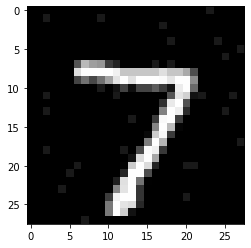

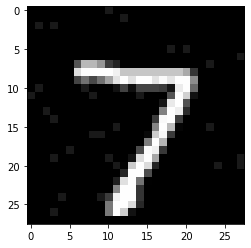

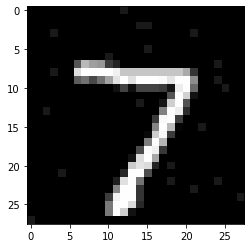

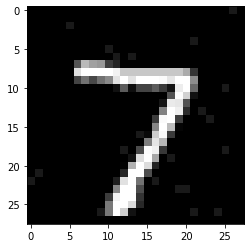

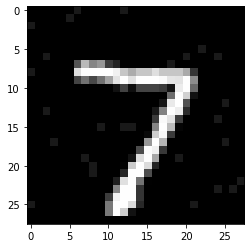

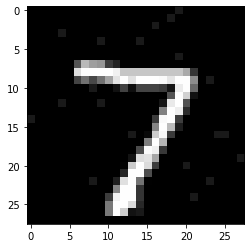

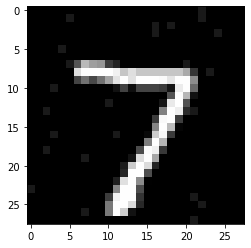

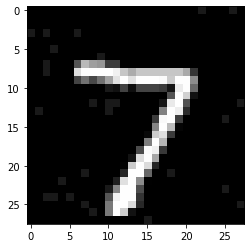

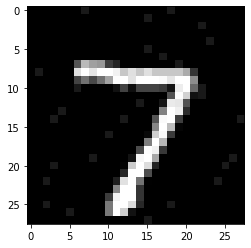

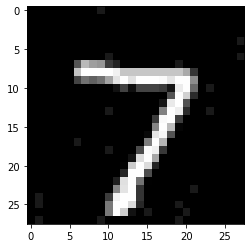

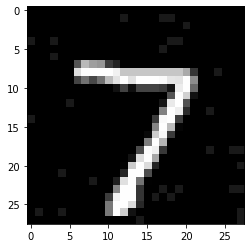

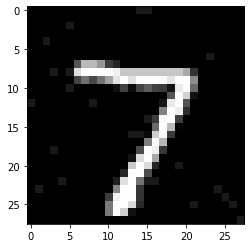

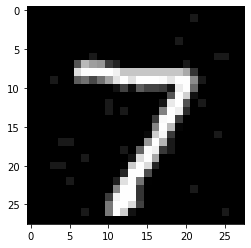

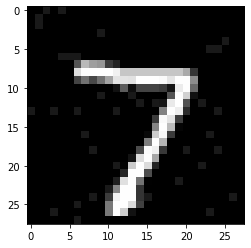

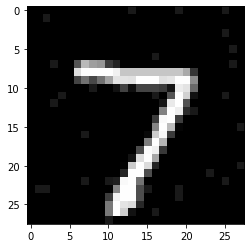

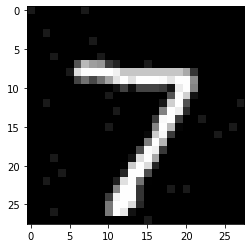

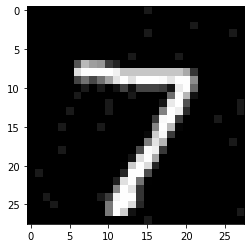

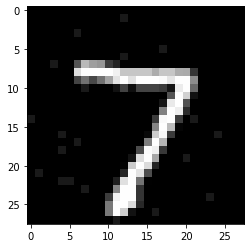

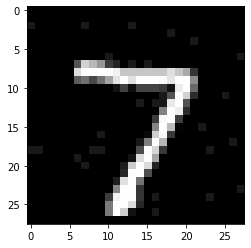

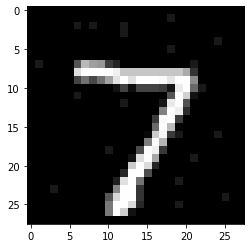

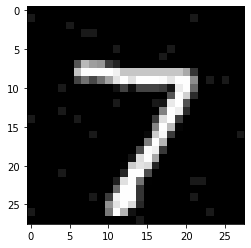

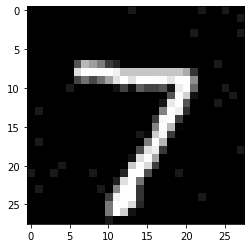

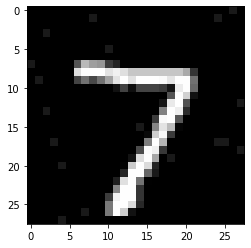

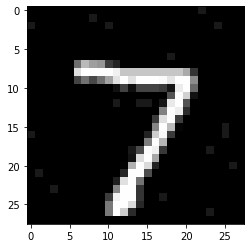

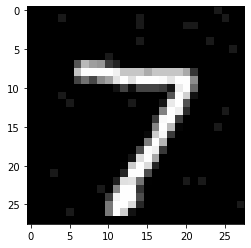

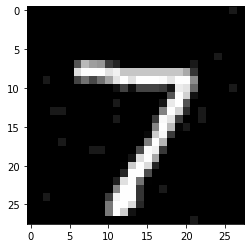

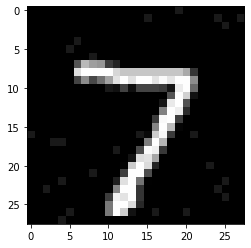

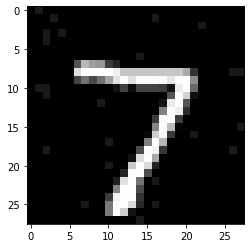

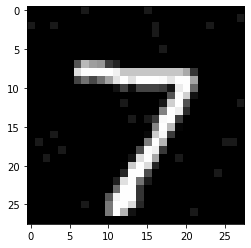

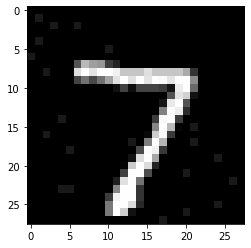

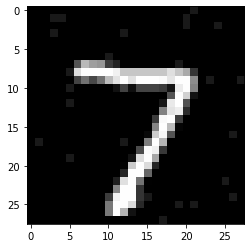

In [4]:
#产生扰动种群
x_des = []
for r in range(100):
    for i in range(28):
        for j in range(28):
            x= random.randint(0,10000)/10000
            if x <= 0.1:
                u = x_tmp[i,j] # 期望值μ
                sig = math.sqrt(0.2) # 标准差δ
                x_ = random.uniform(u - 3*sig, u + 3*sig)
                y_sig = np.exp(-(x_ - u) ** 2 /(2* sig **2))/(math.sqrt(2*math.pi)*sig)
                y_= random.randint(0,10000)/10000
                if y_ <= y_sig:
                    if x_test[0][i,j] <= 127:
                        x_tmp[i,j] += 255*0.1
                    elif x_test[0][i,j] > 127 and x_test[0][i,j] < 229:
                        y = random.randint(0,10000)/10000
                        if y <= 0.5:
                            x_tmp[i,j] += 255*0.1
                        else:
                            x_tmp[i,j] -= 255*0.1
                    elif x_test[0][i,j] >= 229:
                        x_tmp[i,j] -= 255*0.1
    x_t = x_tmp/255-x_test[0]/255
    #x_des.append(np.array (x_t.reshape(1,784)))
    x_des.append(np.array(x_t.reshape(1,784)))
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [5]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [6]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [7]:
x_train = x_train / 255
x_test = x_test / 255 

In [8]:
model = load_model('mnist_model.h5')

In [9]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [10]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [11]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #while GENERATION < MAX_GENERATION:
        while Func(BEST_X) >= 0.4:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Func(BEST_X) <= F:
                print("resume")
                D += 0.5 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #while GENERATION < MAX_GENERATION:
        while Func(BEST_X) >= 0.4:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            
            
            if Dis(BEST_X) <= D:
                # 过滤
                for i in range(784):
                    if BEST_X[i] < 0.15 :
                        BEST_X[i] = 0
                print("过滤：","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                print("attack")
                F -= 0.1
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [12]:
#MAX_GENERATION = 500  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.8   #置信度参数
D = 3.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "attack")
re = Re(cond, "resume")

GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()
if Func(BEST_X) < 0.4:
    BEST_F = BEST_X+x_test[0]
    #print(BEST_X_F)
    plt.imshow(BEST_F.reshape(28,28),cmap='gray')
    plt.show()
    #break

attack
最优值： 0.99664176 扰动程度： 0.4917647058823533 代数： 1
最优值： 0.99645835 扰动程度： 0.36814729911572497 代数： 2
最优值： 0.9964742 扰动程度： 0.3704727443435546 代数： 3
最优值： 0.9963021 扰动程度： 0.3765850855086604 代数： 4
最优值： 0.9962225 扰动程度： 0.3820977980816547 代数： 5
最优值： 0.99612916 扰动程度： 0.45663066764330984 代数： 6
最优值： 0.99593484 扰动程度： 0.4545956803671225 代数： 7
最优值： 0.9957112 扰动程度： 0.47215546236646816 代数： 8
最优值： 0.9954587 扰动程度： 0.5403195642230434 代数： 9
最优值： 0.99544805 扰动程度： 0.5425658618733714 代数： 10
最优值： 0.9951143 扰动程度： 0.5916569689845719 代数： 11
最优值： 0.9949267 扰动程度： 0.5824698768192804 代数： 12
最优值： 0.9948525 扰动程度： 0.5810030988382013 代数： 13
最优值： 0.99460226 扰动程度： 0.6126958991685828 代数： 14
最优值： 0.9943082 扰动程度： 0.4917240383649279 代数： 15
最优值： 0.9943082 扰动程度： 0.4917240383649279 代数： 16
最优值： 0.99412656 扰动程度： 0.5181442678085165 代数： 17
最优值： 0.9942011 扰动程度： 0.5146488666079754 代数： 18
最优值： 0.99413836 扰动程度： 0.5218332643286203 代数： 19
最优值： 0.99395645 扰动程度： 0.6053322809961347 代数： 20
最优值： 0.9938134 扰动程度： 0.5914689704782207 代数： 21
最优值

最优值： 0.87430197 扰动程度： 3.9829055753162352 代数： 174
最优值： 0.87158734 扰动程度： 3.9895823939834503 代数： 175
最优值： 0.87021554 扰动程度： 4.028047892041633 代数： 176
最优值： 0.86592734 扰动程度： 4.117189223200419 代数： 177
最优值： 0.86304885 扰动程度： 4.157916936618505 代数： 178
最优值： 0.8611224 扰动程度： 4.1449536320471765 代数： 179
最优值： 0.85850585 扰动程度： 4.17267110974032 代数： 180
最优值： 0.857758 扰动程度： 4.168562207991674 代数： 181
最优值： 0.8561141 扰动程度： 4.1971475315475555 代数： 182
最优值： 0.8566682 扰动程度： 4.189424707432098 代数： 183
最优值： 0.85459805 扰动程度： 4.217671734783431 代数： 184
最优值： 0.85344654 扰动程度： 4.240550207141225 代数： 185
最优值： 0.8529663 扰动程度： 4.282460754916912 代数： 186
最优值： 0.8501692 扰动程度： 4.236827301450525 代数： 187
最优值： 0.84533405 扰动程度： 4.289907984361895 代数： 188
最优值： 0.841351 扰动程度： 4.377817860734738 代数： 189
最优值： 0.8383909 扰动程度： 4.447858220514617 代数： 190
最优值： 0.83895737 扰动程度： 4.385312062365402 代数： 191
最优值： 0.83677536 扰动程度： 4.438886087908633 代数： 192
最优值： 0.83426243 扰动程度： 4.464872353255404 代数： 193
最优值： 0.83215934 扰动程度： 4.561076762280068 代数： 194

最优值： 0.8095522 扰动程度： 4.243150572916885 代数： 346
最优值： 0.81474966 扰动程度： 4.184778259005054 代数： 347
最优值： 0.8163269 扰动程度： 4.1745986835411735 代数： 348
最优值： 0.81728786 扰动程度： 4.177388710685123 代数： 349
最优值： 0.8235551 扰动程度： 4.106042869244748 代数： 350
最优值： 0.8227065 扰动程度： 4.05655931191414 代数： 351
最优值： 0.8303888 扰动程度： 4.022140244825195 代数： 352
最优值： 0.83361906 扰动程度： 3.9318553132341463 代数： 353
过滤： 最优值： 0.96284646 扰动程度： 2.92926198555606
attack
最优值： 0.88178307 扰动程度： 3.758671913809264 代数： 354
最优值： 0.83678323 扰动程度： 3.930959016536757 代数： 355
最优值： 0.83471394 扰动程度： 3.9285450726854254 代数： 356
最优值： 0.8354637 扰动程度： 3.908792252566422 代数： 357
最优值： 0.8334541 扰动程度： 3.9395753880011863 代数： 358
最优值： 0.83533645 扰动程度： 3.9357383755186146 代数： 359
最优值： 0.83123505 扰动程度： 3.970857637399487 代数： 360
最优值： 0.8265927 扰动程度： 4.048998199177612 代数： 361
最优值： 0.8158667 扰动程度： 4.1488463446086525 代数： 362
最优值： 0.807447 扰动程度： 4.246865246608259 代数： 363
最优值： 0.80201703 扰动程度： 4.31956449295951 代数： 364
最优值： 0.800015 扰动程度： 4.341295035915628 代数： 365

最优值： 0.512972 扰动程度： 6.845477243063933 代数： 517
最优值： 0.5041838 扰动程度： 6.919455488854974 代数： 518
最优值： 0.495852 扰动程度： 7.002275895058864 代数： 519
resume
最优值： 0.5045321 扰动程度： 6.868320214279439 代数： 520
最优值： 0.51388186 扰动程度： 6.837088907650473 代数： 521
最优值： 0.5227268 扰动程度： 6.639938548185626 代数： 522
最优值： 0.5287555 扰动程度： 6.575994354707504 代数： 523
最优值： 0.5350166 扰动程度： 6.501738352353345 代数： 524
最优值： 0.5432991 扰动程度： 6.384226185632803 代数： 525
最优值： 0.5438627 扰动程度： 6.381018976758251 代数： 526
最优值： 0.54807836 扰动程度： 6.3452162985984435 代数： 527
最优值： 0.55527735 扰动程度： 6.313397466388465 代数： 528
最优值： 0.561284 扰动程度： 6.27072209020134 代数： 529
最优值： 0.57065815 扰动程度： 6.182293852660607 代数： 530
最优值： 0.577836 扰动程度： 6.152992556340258 代数： 531
最优值： 0.58711296 扰动程度： 5.981972463596146 代数： 532
最优值： 0.5858917 扰动程度： 5.995574409247414 代数： 533
最优值： 0.5955059 扰动程度： 5.926153992481484 代数： 534
最优值： 0.59159195 扰动程度： 5.955283034878163 代数： 535
最优值： 0.597843 扰动程度： 5.897093513935056 代数： 536
最优值： 0.59879726 扰动程度： 5.878978494331794 代数： 537
最优值：

In [13]:
BEST_X

array([ 1.66822116e-02,  0.00000000e+00,  0.00000000e+00,  4.91834409e-04,
       -0.00000000e+00,  0.00000000e+00,  3.34305483e-01,  0.00000000e+00,
        0.00000000e+00,  3.11940900e-02,  1.06298044e-04,  1.34605833e-03,
        1.61499133e-03,  2.21916815e-02,  2.19640999e-03,  3.88966993e-02,
        9.14957647e-04,  9.13608495e-04,  5.50500295e-02,  0.00000000e+00,
        2.41157168e-01,  1.01449895e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.41361331e-05,  2.52518089e-01,
        0.00000000e+00,  0.00000000e+00,  1.57915061e-02,  0.00000000e+00,
        2.27136789e-04,  1.67311145e-02,  0.00000000e+00,  7.17740393e-06,
        0.00000000e+00,  2.51355768e-01,  2.18982934e-02,  0.00000000e+00,
        0.00000000e+00,  1.96022660e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.69155097e-03,  2.38404152e-02,  1.14188271e-03,
        8.48007459e-02,  1.34509183e-02,  4.71827276e-05,  0.00000000e+00,
        5.85187286e-06,  

In [11]:
BEST_X=np.array([ 1.66822116e-02,  0.00000000e+00,  0.00000000e+00,  4.91834409e-04,
       -0.00000000e+00,  0.00000000e+00,  3.34305483e-01,  0.00000000e+00,
        0.00000000e+00,  3.11940900e-02,  1.06298044e-04,  1.34605833e-03,
        1.61499133e-03,  2.21916815e-02,  2.19640999e-03,  3.88966993e-02,
        9.14957647e-04,  9.13608495e-04,  5.50500295e-02,  0.00000000e+00,
        2.41157168e-01,  1.01449895e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.41361331e-05,  2.52518089e-01,
        0.00000000e+00,  0.00000000e+00,  1.57915061e-02,  0.00000000e+00,
        2.27136789e-04,  1.67311145e-02,  0.00000000e+00,  7.17740393e-06,
        0.00000000e+00,  2.51355768e-01,  2.18982934e-02,  0.00000000e+00,
        0.00000000e+00,  1.96022660e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.69155097e-03,  2.38404152e-02,  1.14188271e-03,
        8.48007459e-02,  1.34509183e-02,  4.71827276e-05,  0.00000000e+00,
        5.85187286e-06,  2.83172601e-03,  1.95480428e-01,  0.00000000e+00,
        6.20838039e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.27050749e-01,  2.09532788e-05,  1.73178882e-04,  6.42427365e-03,
        0.00000000e+00,  7.54858716e-02,  1.39087430e-02,  0.00000000e+00,
        6.77794296e-05,  9.46674413e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.86187133e-01,  8.13087610e-02,  2.91305045e-11,
        7.49624253e-04,  1.56411227e-01,  0.00000000e+00,  0.00000000e+00,
        1.87249201e-04,  6.64931805e-02,  6.34614038e-04,  0.00000000e+00,
        2.62966619e-03,  0.00000000e+00,  2.94627257e-05,  0.00000000e+00,
        3.15749158e-02,  6.96393807e-03,  4.34711784e-03,  2.86246440e-05,
        4.68121119e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.02442695e-03,  0.00000000e+00,  0.00000000e+00,  2.07597442e-05,
        0.00000000e+00,  9.47048733e-02,  0.00000000e+00,  1.42899745e-02,
        8.64810233e-03,  2.03198661e-01, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.16573926e-04,  2.15932915e-02,  3.05329530e-02,  0.00000000e+00,
        0.00000000e+00,  2.54096985e-02,  3.58053554e-04, -0.00000000e+00,
        0.00000000e+00,  1.31870791e-03,  0.00000000e+00,  4.87682655e-01,
        1.84939071e-01,  7.80247398e-01,  9.51472713e-02,  1.23398538e-03,
        0.00000000e+00,  1.10347396e-01,  0.00000000e+00,  4.51701127e-05,
        1.81980659e-03,  0.00000000e+00,  0.00000000e+00,  2.44926395e-03,
        0.00000000e+00,  4.45276129e-02,  5.12944629e-03,  5.27534057e-07,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  3.72759455e-03,
        3.04384520e-02,  5.79083912e-03,  4.89376451e-02,  3.79326681e-05,
        3.05602433e-01,  0.00000000e+00,  6.02304429e-04,  0.00000000e+00,
        2.02390725e-01,  2.47998615e-01,  4.15057770e-01,  1.75958311e-01,
        1.95942581e-01,  6.28199555e-01,  3.27577491e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.40887305e-04,  3.90903136e-03,
        1.80681479e-03,  0.00000000e+00,  5.08484426e-02,  5.96565642e-03,
       -0.00000000e+00,  0.00000000e+00,  1.41529837e-04,  1.42458167e-05,
        0.00000000e+00,  3.72791658e-02,  1.58586495e-02,  1.81155445e-01,
        0.00000000e+00,  1.56740143e-01,  2.04816192e-01,  0.00000000e+00,
        2.34972900e-04,  3.19704692e-01,  5.37040791e-02,  2.18592171e-01,
        1.49727350e-01,  8.27565709e-04,  0.00000000e+00,  1.45008711e-02,
        1.90686320e-05,  7.45198780e-04,  1.45170133e-02,  0.00000000e+00,
        3.34565854e-03,  0.00000000e+00,  0.00000000e+00,  5.64425923e-02,
        0.00000000e+00,  0.00000000e+00,  7.91210415e-02,  0.00000000e+00,
        9.66924195e-03,  2.26937316e-04, -1.06351570e-01,  0.00000000e+00,
        3.69535392e-02,  1.67173326e-01, -1.53689292e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.87650883e-03,  1.59782927e-01,
        0.00000000e+00,  0.00000000e+00,  5.24769390e-04,  5.44241933e-06,
        0.00000000e+00,  9.05155016e-03,  0.00000000e+00,  5.80784745e-05,
        1.02402347e-06,  0.00000000e+00,  7.70874817e-04,  0.00000000e+00,
        0.00000000e+00,  4.45208391e-02,  0.00000000e+00,  3.71189245e-08,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.66534284e-02,
       -6.89120604e-02, -6.54827433e-02,  3.16515742e-03, -3.92903096e-03,
        6.36065515e-04,  6.24650350e-03,  0.00000000e+00, -7.66455360e-02,
       -1.29810526e-01,  1.39092670e-03,  2.12882889e-01,  2.22971168e-03,
        1.35488152e-02, -2.44356414e-03,  6.63891066e-05, -0.00000000e+00,
        0.00000000e+00,  8.06930799e-03,  2.39528383e-01,  0.00000000e+00,
        0.00000000e+00,  8.16794921e-03,  5.81835374e-04,  0.00000000e+00,
        0.00000000e+00,  3.34805484e-04,  0.00000000e+00,  0.00000000e+00,
       -6.11291915e-03,  7.60384336e-03, -2.52745935e-01, -3.90499014e-01,
       -1.36857981e-01, -2.62929811e-01,  0.00000000e+00, -4.27178320e-02,
       -2.63228891e-01, -6.20850068e-02, -2.93534668e-01,  2.28626044e-03,
       -1.98728278e-03, -1.50091597e-03,  6.23894223e-02,  6.64120494e-04,
        6.54969211e-04,  2.66570560e-02,  4.08269851e-04,  8.86422167e-03,
        4.35296957e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.96731453e-05,  0.00000000e+00,  1.66437618e-04,
        8.53762602e-05,  0.00000000e+00,  7.00323736e-04,  0.00000000e+00,
       -6.46255244e-03, -1.92421654e-03, -3.62774180e-02, -9.30766913e-04,
        0.00000000e+00, -1.05991207e-01, -2.63731091e-03, -1.67707034e-01,
       -1.24008928e-03,  4.22582966e-03,  0.00000000e+00,  1.33555586e-01,
        0.00000000e+00,  1.90316462e-01,  1.57543305e-03,  5.08137277e-03,
        2.93782024e-04,  0.00000000e+00,  0.00000000e+00,  1.25513513e-02,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  9.91958929e-04,  0.00000000e+00,
        2.61969659e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.25999935e-03,  0.00000000e+00, -3.00358365e-03,  2.71237675e-04,
       -1.59776237e-02, -4.24141061e-02,  1.33046413e-06,  7.34114158e-04,
        1.44562045e-03,  0.00000000e+00,  0.00000000e+00,  3.45347013e-02,
        1.80102883e-04,  4.39192318e-05,  1.10388712e-02,  0.00000000e+00,
        0.00000000e+00,  3.11032810e-03,  0.00000000e+00,  0.00000000e+00,
        3.64996349e-04,  5.19162479e-06,  2.20370830e-04,  0.00000000e+00,
        8.25200456e-02,  2.76718013e-01,  4.14510069e-01,  4.69691384e-01,
        0.00000000e+00, -8.28348051e-02, -2.27576024e-02, -2.34095594e-03,
       -1.22709617e-01,  0.00000000e+00,  0.00000000e+00,  6.87797842e-02,
        0.00000000e+00,  2.63985259e-03,  3.73217628e-04,  0.00000000e+00,
        0.00000000e+00,  4.40538170e-02,  0.00000000e+00,  2.27377718e-04,
        0.00000000e+00,  0.00000000e+00,  2.60964453e-03,  0.00000000e+00,
        0.00000000e+00,  1.86043667e-02,  0.00000000e+00,  4.62934905e-01,
        4.85834933e-04,  0.00000000e+00,  1.57137403e-03,  6.67646080e-06,
        0.00000000e+00, -1.59503623e-03, -1.02401453e-02,  0.00000000e+00,
       -1.63384459e-01,  1.02556325e-06,  0.00000000e+00,  8.59761401e-05,
        8.46896810e-06,  2.02594462e-01,  1.05284085e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.43250617e-02,  9.65296219e-03,
        4.25807705e-03,  0.00000000e+00,  7.32653985e-05,  8.63422068e-03,
        1.69988582e-04,  0.00000000e+00,  1.34407554e-01, -0.00000000e+00,
        6.41682670e-01,  2.38852063e-01,  0.00000000e+00,  2.03063270e-05,
       -6.33559198e-02,  0.00000000e+00,  2.85297735e-03,  1.64422202e-04,
        2.24279914e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.35005201e-01,  0.00000000e+00,  0.00000000e+00,  7.18148326e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.96000188e-03,  1.09503458e-06,  2.31399536e-01,
        1.37533238e-01, -0.00000000e+00,  5.43403450e-01,  1.52260743e-02,
        0.00000000e+00,  0.00000000e+00, -1.67456715e-01, -1.87461279e-02,
        0.00000000e+00,  2.16239849e-03,  1.05739118e-02,  1.06738737e-02,
        6.80018277e-03,  1.58784650e-02,  0.00000000e+00,  0.00000000e+00,
        3.61806835e-04,  0.00000000e+00,  0.00000000e+00,  7.15631088e-04,
        0.00000000e+00,  7.83412933e-04,  6.56272481e-05,  0.00000000e+00,
        1.47617081e-04, -0.00000000e+00,  5.76401637e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.47035102e-02,
        0.00000000e+00, -4.42305618e-03, -4.09972074e-02,  9.99160782e-03,
        2.10091280e-04,  6.17338700e-03,  0.00000000e+00,  4.15433443e-01,
        4.18033499e-03,  1.58725691e-01,  0.00000000e+00,  1.39721322e-01,
        1.45967966e-02,  9.20392374e-05,  3.21789109e-01,  1.48556674e-01,
        0.00000000e+00,  0.00000000e+00,  1.98340103e-03,  8.30579403e-05,
        1.04582971e-01,  2.24347871e-03,  3.28310660e-02,  0.00000000e+00,
        3.00823049e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.00327166e-01,  2.46716422e-03,  0.00000000e+00,  2.80042080e-01,
        5.64921691e-06,  1.53993075e-01,  0.00000000e+00,  1.01723539e-01,
        0.00000000e+00,  6.42051970e-03,  6.88010458e-02,  9.27442549e-03,
        0.00000000e+00,  6.09695618e-03, -0.00000000e+00,  1.93832930e-01,
        0.00000000e+00,  4.98146521e-02,  0.00000000e+00,  0.00000000e+00,
        2.44558269e-02,  4.07615714e-04,  0.00000000e+00,  0.00000000e+00,
        8.74086691e-02,  0.00000000e+00, -7.80679107e-02, -3.36321780e-02,
       -2.20863713e-02, -2.61093817e-02,  7.69823499e-05,  0.00000000e+00,
        9.94956798e-02,  5.68495922e-05,  7.43124118e-04,  3.17665931e-02,
        0.00000000e+00,  2.01695937e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.23334809e-02,
        0.00000000e+00,  1.91739537e-01,  0.00000000e+00,  3.42392073e-01,
        4.14088973e-02,  0.00000000e+00,  0.00000000e+00,  1.33252094e-01,
        0.00000000e+00, -1.89415386e-02,  1.65659599e-04, -1.08696218e-01,
        1.99618322e-02,  0.00000000e+00,  3.52965989e-01,  0.00000000e+00,
        6.77315879e-04,  1.87557510e-01,  0.00000000e+00,  2.77393046e-01,
        9.57877911e-02,  3.83850237e-02,  4.64321360e-04,  0.00000000e+00,
        0.00000000e+00,  3.95001579e-01,  0.00000000e+00,  0.00000000e+00,
        1.66802150e-02,  0.00000000e+00,  4.09384060e-02,  8.57277117e-03,
        3.05685717e-04,  1.91360469e-01,  6.96253263e-02,  0.00000000e+00,
        1.47943546e-01, -3.29827357e-01,  3.58129491e-03,  3.94568704e-02,
        7.38099444e-02,  2.65872822e-02,  0.00000000e+00,  5.77961905e-02,
        3.94571312e-01,  1.08810577e-02,  3.02394433e-04,  6.37709851e-02,
        0.00000000e+00, -0.00000000e+00,  2.53576460e-02,  0.00000000e+00,
        1.29135959e-02,  0.00000000e+00,  0.00000000e+00,  1.61257102e-03,
        1.66290299e-02,  2.26447028e-01,  2.76288556e-01,  1.52931408e-02,
        0.00000000e+00,  3.60969219e-01,  3.07013284e-03,  3.50874033e-02,
        4.22418782e-03,  3.86888998e-03, -3.99026294e-03,  7.46506483e-03,
        0.00000000e+00,  1.13465892e-01,  9.77294466e-03,  2.15994179e-01,
        4.43149696e-01,  8.43179205e-04,  1.17287119e-02,  1.10774959e-03,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  1.66654171e-03,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.86393684e-01,  1.39538326e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.15166091e-01,
       -1.80769183e-02, -1.03376598e-02,  0.00000000e+00,  2.56706248e-05,
        0.00000000e+00,  4.17988610e-05,  4.73494267e-05,  2.64061068e-02,
        1.62602105e-01,  0.00000000e+00,  1.04942195e-01,  1.61068621e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.70595203e-04,  1.19066782e-02,
        1.65152507e-01,  1.89244849e-05,  4.47945589e-04,  5.11737231e-04,
        1.04158059e-03,  0.00000000e+00,  1.06430490e-01, -4.97213196e-02,
        0.00000000e+00,  0.00000000e+00, -2.33169573e-02,  1.91293667e-02,
        5.25980160e-03,  9.82482246e-04,  0.00000000e+00,  5.19140570e-01,
        0.00000000e+00,  9.63817020e-03,  1.82906019e-03,  1.61259297e-02,
        2.66644711e-04,  9.19891533e-04,  0.00000000e+00,  9.15761605e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.01534083e-03,
        0.00000000e+00,  7.68549618e-02,  1.94054888e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  9.93781806e-02, -2.17551100e-02,
        4.35424200e-05, -3.72622009e-03, -1.13684597e-03,  3.38660339e-05,
        2.10206173e-05,  0.00000000e+00,  5.44645731e-02,  1.36609289e-03,
        4.72729914e-03,  0.00000000e+00,  0.00000000e+00,  8.36775683e-04,
        7.77300800e-02,  0.00000000e+00,  6.60945696e-02,  3.74120599e-06,
        3.41154872e-03,  0.00000000e+00,  5.76478237e-02,  2.88226069e-03,
        0.00000000e+00,  1.24775614e-04,  1.81838546e-03,  0.00000000e+00,
        0.00000000e+00,  1.89516164e-04,  0.00000000e+00, -7.84062796e-02,
        0.00000000e+00, -1.87507839e-01,  0.00000000e+00,  9.15145976e-04,
        0.00000000e+00,  3.43393840e-02,  0.00000000e+00,  0.00000000e+00,
        2.70975954e-03,  6.53233626e-04,  0.00000000e+00,  2.55896224e-04,
        0.00000000e+00,  0.00000000e+00,  3.21094482e-03,  1.11135402e-02,
        1.21698758e-03,  8.68938598e-04,  2.60684473e-03,  0.00000000e+00,
        2.78480421e-05,  0.00000000e+00,  1.09923903e-02,  0.00000000e+00,
        7.14540241e-04,  2.34983803e-04, -5.38030638e-02, -1.70924904e-03,
        1.06477510e-01, -1.26436494e-02,  2.91466124e-03,  0.00000000e+00,
        0.00000000e+00,  8.90392055e-07,  7.45510137e-06,  0.00000000e+00,
        4.03512247e-01,  0.00000000e+00,  2.12704448e-04,  0.00000000e+00,
        4.58492622e-03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        7.01821315e-02,  0.00000000e+00,  0.00000000e+00,  1.66575628e-03,
        1.00319350e-03,  1.91791529e-01,  0.00000000e+00,  0.00000000e+00,
        3.31163184e-03,  8.35187708e-04,  0.00000000e+00,  3.61253919e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.80361559e-02,  5.27394773e-02,  0.00000000e+00,  0.00000000e+00,
        2.01550340e-04,  9.92643290e-03,  2.60739331e-06,  3.13445426e-03,
        1.80158918e-01,  6.95171964e-05,  0.00000000e+00,  3.70585191e-03])

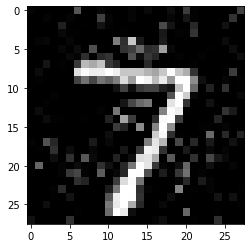

In [12]:
BEST = BEST_X + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [23]:
result=model.predict(BEST_X.reshape(1,784))
result[0]

array([0.03606191, 0.13325453, 0.30351505, 0.14268604, 0.03217717,
       0.18159828, 0.06348677, 0.01640903, 0.07245255, 0.01835869],
      dtype=float32)

In [13]:
# test
count = 0
for i in range(784):
    if BEST_X[i] != 0:
        count+=1
print(count)

473


In [14]:
# test
count = 0
for i in range(784):
    if BEST_X[i] > 0.8:
        count+=1
print(count)

0


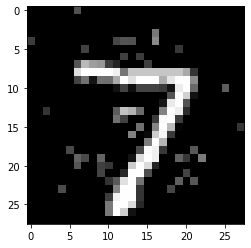

置信度： 0.79100835
[1.5174575e-03 6.5535348e-04 4.4565573e-02 1.5166000e-01 1.2409961e-04
 4.1875131e-03 1.3115628e-05 7.9100835e-01 2.5698482e-03 3.6986568e-03]
扰动程度： 5.808045297534583


In [23]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_f[i]) < 0.2:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

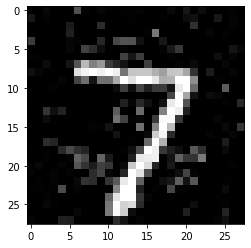

置信度： 0.7140484
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]
扰动程度： 5.399337470712778


In [21]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(BEST_X)
for i in range(784):
    if abs(x_F[i]) > 0.5:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.79081285


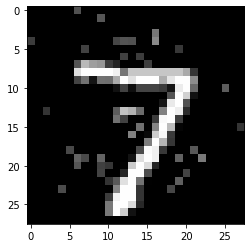

迭代: 2
置信度： 0.78750575


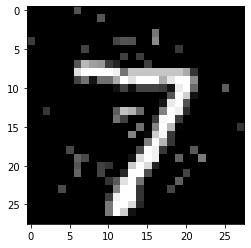

迭代: 3
置信度： 0.7869196


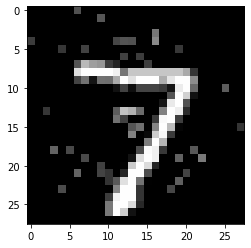

迭代: 4
置信度： 0.7822701


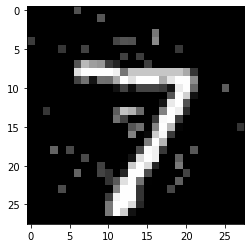

迭代: 5
置信度： 0.78187114


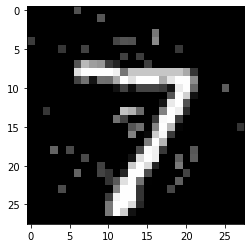

迭代: 6
置信度： 0.777245


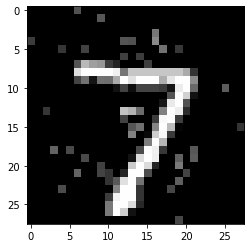

迭代: 7
置信度： 0.7769792


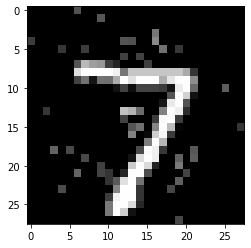

迭代: 8
置信度： 0.77427053


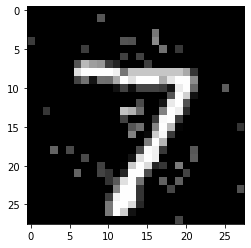

迭代: 9
置信度： 0.7742648


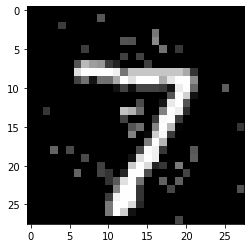

迭代: 10
置信度： 0.77287626


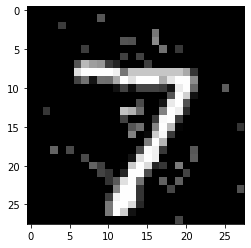

迭代: 11
置信度： 0.7688211


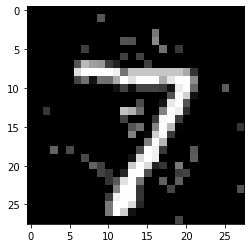

迭代: 12
置信度： 0.76710916


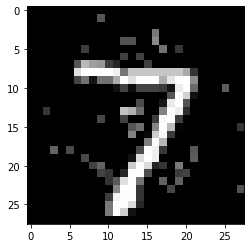

迭代: 13
置信度： 0.76175636


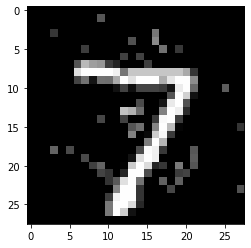

迭代: 14
置信度： 0.754947


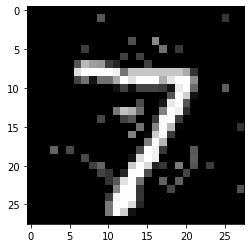

迭代: 15
置信度： 0.73712313


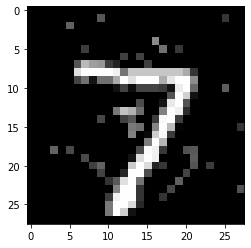

迭代: 16
置信度： 0.73679423


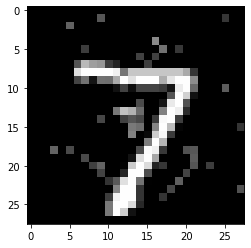

迭代: 17
置信度： 0.7302526


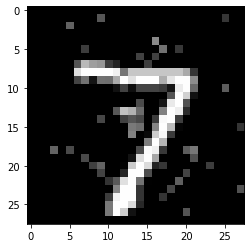

迭代: 18
置信度： 0.7288987


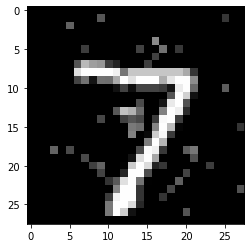

迭代: 19
置信度： 0.72669345


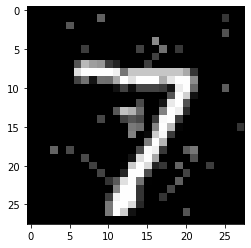

迭代: 20
置信度： 0.7041881


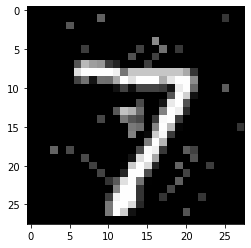

迭代: 21
置信度： 0.69990194


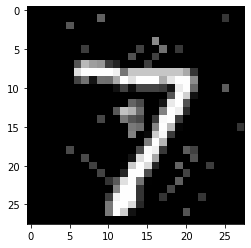

迭代: 22
置信度： 0.69171655


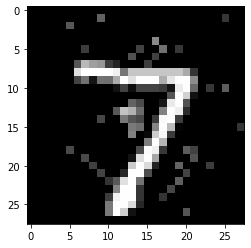

迭代: 23
置信度： 0.69031096


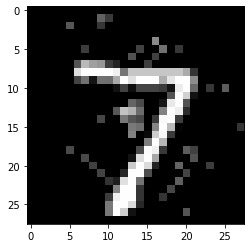

迭代: 24
置信度： 0.6852583


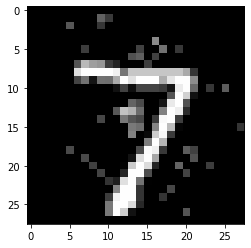

迭代: 25
置信度： 0.6840442


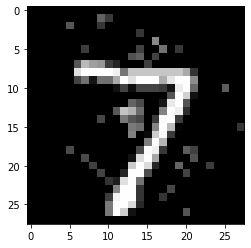

迭代: 26
置信度： 0.672793


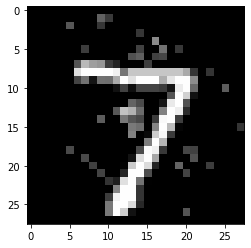

迭代: 27
置信度： 0.6632727


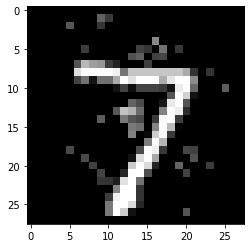

迭代: 28
置信度： 0.6593912


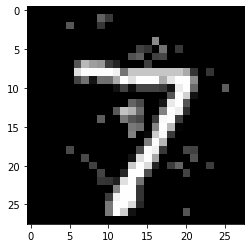

迭代: 29
置信度： 0.65689915


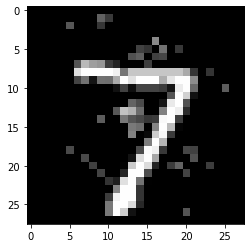

迭代: 30
置信度： 0.642851


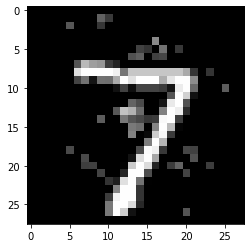

迭代: 31
置信度： 0.6423891


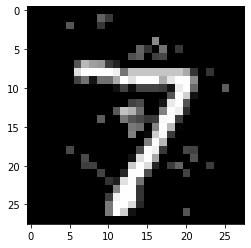

迭代: 32
置信度： 0.6416772


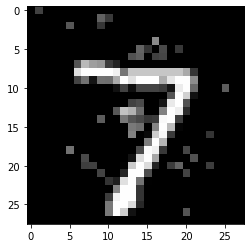

迭代: 33
置信度： 0.6382753


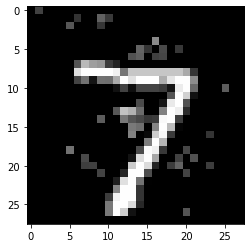

迭代: 34
置信度： 0.6347022


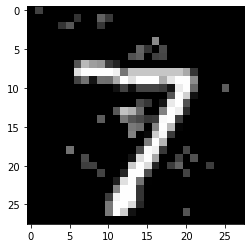

迭代: 35
置信度： 0.6346574


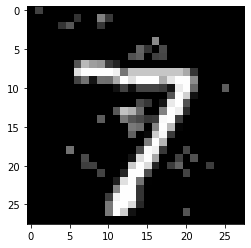

迭代: 36
置信度： 0.6339686


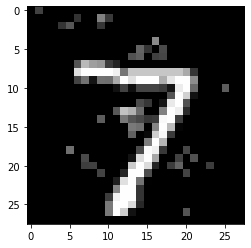

迭代: 37
置信度： 0.63303316


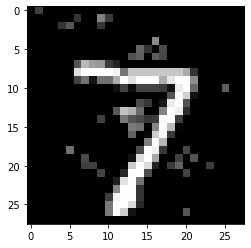

迭代: 38
置信度： 0.6291769


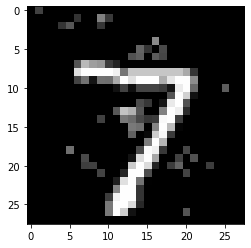

迭代: 39
置信度： 0.6288673


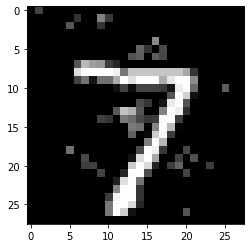

迭代: 40
置信度： 0.6225137


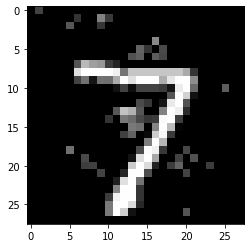

迭代: 41
置信度： 0.6176364


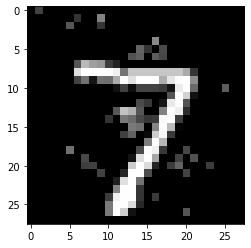

迭代: 42
置信度： 0.61705863


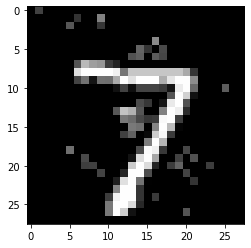

迭代: 43
置信度： 0.611814


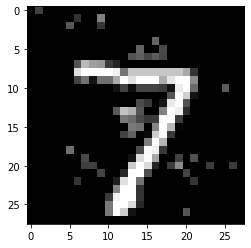

迭代: 44
置信度： 0.6064441


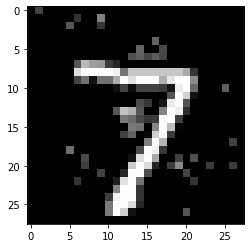

迭代: 45
置信度： 0.5942284


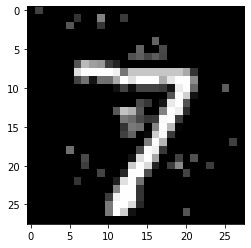

迭代失败


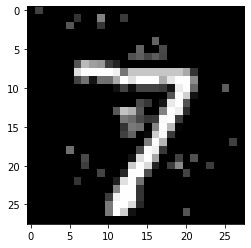

最终置信度： 0.5942284
最终扰动程度： 5.808045297534582
[1.0967220e-03 9.6672133e-04 4.5148227e-02 3.4004280e-01 1.6902824e-04
 4.2748246e-03 1.2764148e-05 5.9422839e-01 6.3656499e-03 7.6948670e-03]


In [24]:
# 改变坐标减小置信度（过滤0.2）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


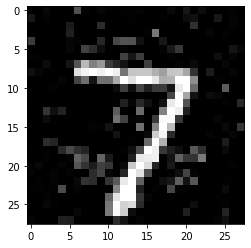

最终置信度： 0.7140484
最终扰动程度： 5.399337470712778
[3.5013091e-03 7.0029777e-04 8.5273638e-02 1.8356721e-01 1.1966820e-04
 6.3261571e-03 2.0771509e-05 7.1404839e-01 3.2437495e-03 3.1988441e-03]


In [22]:
# 改变坐标减小置信度（过滤0.5）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


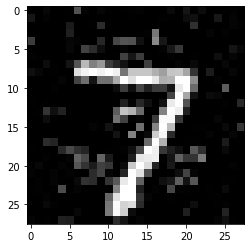

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])